<center>
    <img src="img/scikit-learn-logo.png" width="40%" />
    <br />
    <h1>Robust and calibrated estimators with Scikit-Learn</h1>
    <br /><br />
    Gilles Louppe (<a href="https://twitter.com/glouppe">@glouppe</a>)
    <br /><br />
    New York University
</center>

In [1]:
# Global imports and settings

# Matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.max_open_warning"] = -1

# Print options
import numpy as np
np.set_printoptions(precision=3)

# Slideshow
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {'width': 1440, 'height': 768, 'scroll': True, 'theme': 'simple'})

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

# Utils
from robustness import plot_surface
from robustness import plot_outlier_detector

In [ ]:
%%javascript
Reveal.addEventListener("slidechanged", function(event){ window.location.hash = "header"; });

# Motivation

_In theory,_
- Samples $x$ are drawn from a distribution $P$;
- As data increases, convergence towards the optimal model is guaranteed. 

_In practice,_
- A few samples may be distant from other samples:
    - either because they correspond to rare observations,
    - or because they are due to experimental errors;
- Data is finite:
    - outliers might strongly affect the resulting model.

_Today's goal:_ build models that are robust to outliers!

# Outline

* Motivation
* Novelty and anomaly detection
* Ensembling for robustness 
* From least squares to least absolute deviances
* Calibration

# Novelty and anomaly detection

_Novelty detection:_ 
- Training data is not polluted by outliers, and we are interested in detecting anomalies in new observations.

_Outlier detection:_
- Training data contains outliers, and we need to fit the central mode of the training data, ignoring the deviant observations.

## API

In [ ]:
# Unsupervised learning (no 'y_train')
clf.fit(X_train)

# Detecting novelty or outliers 
y_pred = clf.predict(X_test)             # inliers == 1, outliers == -1
y_score = clf.decision_function(X_test)  # outliers == highest scores

In [169]:
# Generate data
from sklearn.datasets import make_blobs
inliers, _ = make_blobs(n_samples=200, centers=2, random_state=1)
outliers = np.random.rand(50, 2)
outliers = np.min(inliers, axis=0) + (np.max(inliers, axis=0) - np.min(inliers, axis=0)) * outliers

X = np.vstack((inliers, outliers))
ground_truth = np.ones(len(X), dtype=np.int)
ground_truth[-len(outliers):] = 0

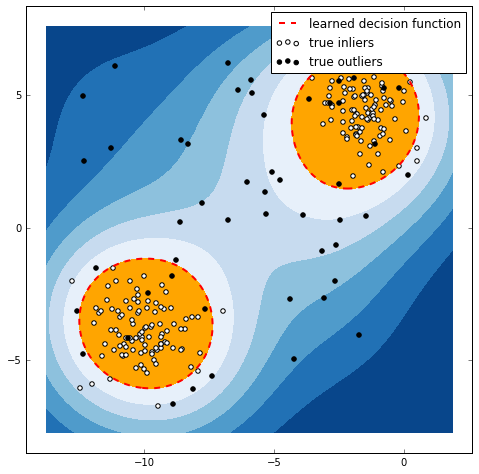

In [170]:
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

# Unsupervised learning
clf = OneClassSVM(nu=0.4, kernel="rbf", gamma=0.1)
# clf = EllipticEnvelope(contamination=.1)
# clf = IsolationForest(max_samples=100)
clf.fit(X)

plot_outlier_detector(clf, X, ground_truth)

# Ensembling for robustness

## Bias-variance decomposition

__Theorem.__ For the _squared error loss_, the bias-variance decomposition of the expected
generalization error at $X=\mathbf{x}$ is

$$
\mathbb{E}_{\cal L} \{ Err(\varphi_{\cal L}(\mathbf{x})) \} = \text{noise}(\mathbf{x}) + \text{bias}^2(\mathbf{x}) + \text{var}(\mathbf{x})
$$



<center>
    <img src="img/bv.png" width="50%" />
</center>

## Variance and robustness

- Low variance implies robustness to outliers
- High variance implies sensitivity to data pecularities


## Ensembling reduces variance 

__Theorem.__ For the _squared error loss_, the bias-variance decomposition of the expected generalization error at $X=x$ of an ensemble of $M$ randomized models $\varphi_{{\cal L},\theta_m}$ is

$$
\mathbb{E}_{\cal L} \{ Err(\psi_{{\cal L},\theta_1,\dots,\theta_M}(\mathbf{x})) \} = \text{noise}(\mathbf{x}) + \text{bias}^2(\mathbf{x}) + \text{var}(\mathbf{x})
$$

where
\begin{align*}
\text{noise}(\mathbf{x}) &= Err(\varphi_B(\mathbf{x})), \\
\text{bias}^2(\mathbf{x}) &= (\varphi_B(\mathbf{x}) - \mathbb{E}_{{\cal L},\theta} \{ \varphi_{{\cal L},\theta}(\mathbf{x}) \} )^2, \\
\text{var}(\mathbf{x}) &= \rho(\mathbf{x}) \sigma^2_{{\cal L},\theta}(\mathbf{x}) + \frac{1 - \rho(\mathbf{x})}{M} \sigma^2_{{\cal L},\theta}(\mathbf{x}).
\end{align*}

In [171]:
# Load data
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data[:, [0, 1]]
y = iris.target

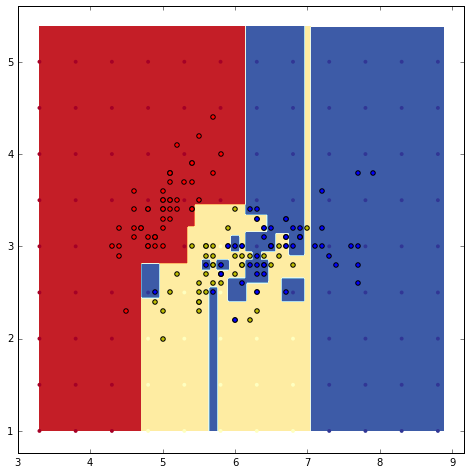

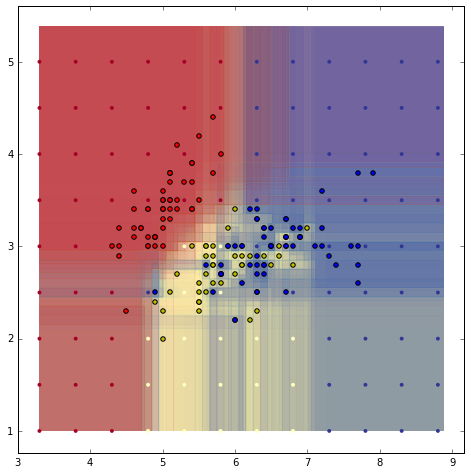

In [172]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

clf = DecisionTreeClassifier().fit(X, y)
plot_surface(clf, X, y)
clf = RandomForestClassifier(n_estimators=100).fit(X, y)
plot_surface(clf, X, y)

# From least squares to least absolute deviances

## Robust learning

- Most methods minimize the mean squared error $\frac{1}{N} \sum_i (y_i - \varphi(x_i))^2$
- By definition, squaring residuals gives emphasis to large residuals.
- Outliers are thus very likely to have a significant effect.

- A robust alternative is to minimize instead the mean absolute deviation $\frac{1}{N} \sum_i |y_i - \varphi(x_i)|$
- Large residuals are therefore given much less emphasis. 

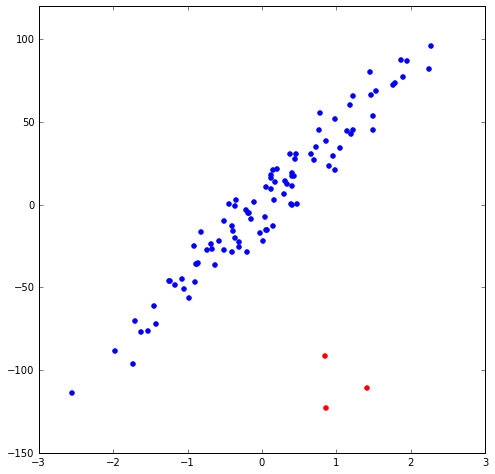

In [216]:
# Generate data
from sklearn.datasets import make_regression
np.random.seed(1)

n_samples = 100
n_outliers = 3
X, y, coef = make_regression(n_samples=n_samples, n_features=1, n_informative=1, noise=10,
                             coef=True, random_state=0)

X[-n_outliers:] = 1 + 0.25 * np.random.normal(size=(n_outliers, 1))
y[-n_outliers:] = -100 + 10 * np.random.normal(size=n_outliers)

plt.scatter(X[:-n_outliers], y[:-n_outliers], color="b")
plt.scatter(X[-n_outliers:], y[-n_outliers:], color="r")
plt.xlim(-3, 3)
plt.ylim(-150, 120)
plt.show()

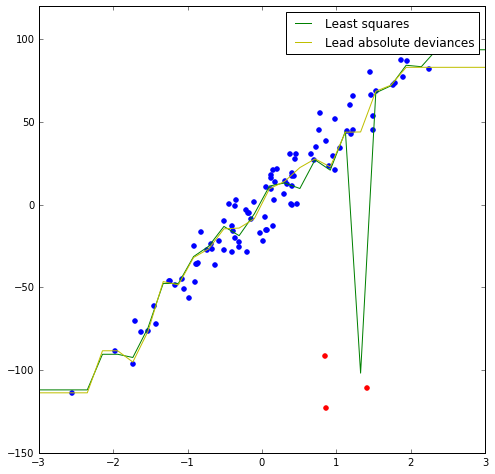

In [218]:
from sklearn.ensemble import GradientBoostingRegressor

clf_ls = GradientBoostingRegressor(loss="ls")
clf_lad = GradientBoostingRegressor(loss="lad")
clf_ls.fit(X, y)
clf_lad.fit(X, y)
X_test = np.linspace(-5, 5).reshape(-1, 1)

plt.scatter(X[:-n_outliers], y[:-n_outliers], color="b")
plt.scatter(X[-n_outliers:], y[-n_outliers:], color="r")
plt.plot(X_test, clf_ls.predict(X_test), "g", label="Least squares")
plt.plot(X_test, clf_lad.predict(X_test), "y", label="Lead absolute deviances")
plt.xlim(-3, 3)
plt.ylim(-150, 120)
plt.legend()
plt.show()

## Robust scaling

- Standardization of a dataset is a common requirement for many machine learning estimators. 
- Typically this is done by removing the mean and scaling to unit variance. 

- For similar reasons as before, outliers can influence the sample mean / variance in a negative way. 
- In such cases, the median and the interquartile range often give better results.

In [212]:
# Generate data
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
X, y = make_blobs(n_samples=100, centers=[(0, 0), (-1, 0)], random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
X_train[0, 0] = -1000  # a fairly large outlier

In [213]:
# Scale data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

standard_scaler = StandardScaler()
Xtr_s = standard_scaler.fit_transform(X_train)
Xte_s = standard_scaler.transform(X_test)

robust_scaler = RobustScaler()
Xtr_r = robust_scaler.fit_transform(X_train)
Xte_r = robust_scaler.transform(X_test)

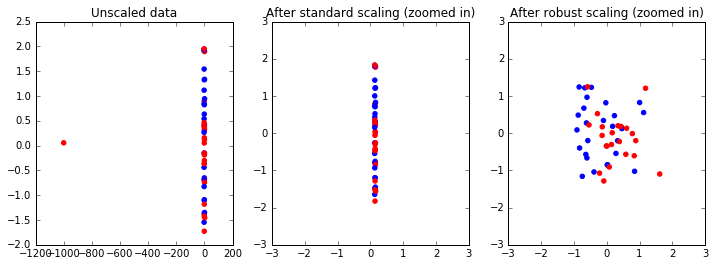

In [214]:
# Plot data
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].scatter(X_train[:, 0], X_train[:, 1], color=np.where(y_train == 0, 'r', 'b'))
ax[1].scatter(Xtr_s[:, 0], Xtr_s[:, 1], color=np.where(y_train == 0, 'r', 'b'))
ax[2].scatter(Xtr_r[:, 0], Xtr_r[:, 1], color=np.where(y_train == 0, 'r', 'b'))
ax[0].set_title("Unscaled data")
ax[1].set_title("After standard scaling (zoomed in)")
ax[2].set_title("After robust scaling (zoomed in)")

# for the scaled data, we zoom in to the data center (outlier can't be seen!)
for a in ax[1:]:
    a.set_xlim(-3, 3)
    a.set_ylim(-3, 3)
    
plt.show()

In [215]:
# Classify using k-NN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(Xtr_s, y_train)
acc_s = knn.score(Xte_s, y_test)
print("Test set accuracy using standard scaler: %.3f" % acc_s)

knn.fit(Xtr_r, y_train)
acc_r = knn.score(Xte_r, y_test)
print("Test set accuracy using robust scaler:   %.3f" % acc_r)

Test set accuracy using standard scaler: 0.460
Test set accuracy using robust scaler:   0.680


# Calibration

In [ ]:
- lien avec regression

In [ ]:
# %load http://scikit-learn.org/dev/_downloads/plot_calibration.py
"""
======================================
Probability calibration of classifiers
======================================

When performing classification you often want to predict not only
the class label, but also the associated probability. This probability
gives you some kind of confidence on the prediction. However, not all
classifiers provide well-calibrated probabilities, some being over-confident
while others being under-confident. Thus, a separate calibration of predicted
probabilities is often desirable as a postprocessing. This example illustrates
two different methods for this calibration and evaluates the quality of the
returned probabilities using Brier's score
(see https://en.wikipedia.org/wiki/Brier_score).

Compared are the estimated probability using a Gaussian naive Bayes classifier
without calibration, with a sigmoid calibration, and with a non-parametric
isotonic calibration. One can observe that only the non-parametric model is able
to provide a probability calibration that returns probabilities close to the
expected 0.5 for most of the samples belonging to the middle cluster with
heterogeneous labels. This results in a significantly improved Brier score.
"""
print(__doc__)

# Author: Mathieu Blondel <mathieu@mblondel.org>
#         Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Balazs Kegl <balazs.kegl@gmail.com>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split


n_samples = 50000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0,
                  centers=centers, shuffle=False, random_state=42)

y[:n_samples // 2] = 0
y[n_samples // 2:] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = \
    train_test_split(X, y, sample_weight, test_size=0.9, random_state=42)

# Gaussian Naive-Bayes with no calibration
clf = GaussianNB()
clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
clf_isotonic.fit(X_train, y_train, sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid')
clf_sigmoid.fit(X_train, y_train, sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

print("Brier scores: (the smaller the better)")

clf_score = brier_score_loss(y_test, prob_pos_clf, sw_test)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sw_test)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sw_test)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

###############################################################################
# Plot the data and the predicted probabilities
plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50, c=color, alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

plt.figure()
order = np.lexsort((prob_pos_clf, ))
plt.plot(prob_pos_clf[order], 'r', label='No calibration (%1.3f)' % clf_score)
plt.plot(prob_pos_isotonic[order], 'g', linewidth=3,
         label='Isotonic calibration (%1.3f)' % clf_isotonic_score)
plt.plot(prob_pos_sigmoid[order], 'b', linewidth=3,
         label='Sigmoid calibration (%1.3f)' % clf_sigmoid_score)
plt.plot(np.linspace(0, y_test.size, 51)[1::2],
         y_test[order].reshape(25, -1).mean(1),
         'k', linewidth=3, label=r'Empirical')
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability "
           "(uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()


# Summary

For robust and calibrated estimators:
- remove outliers before training;
- reduce variance by ensembling estimators;
- drive your analysis with loss functions that are robust to outliers;
    - avoid the squared error loss!
- calibrate the output of your classifier if probabilities are important for your problem.

In [ ]:
questions?